###  Heston's Stochastic Volatility Model for Option Prcing and Delta calculation

Pricing European options and calculate thier Delta using the Black-Scholes model

This provides functions for pricing European call and put options using the Heston stochastic volatility model. 
The implementation uses semi-analytical integration via the characteristic function.


#### Semi-Analytical Method using Fourier Integral
We use the Carr-Madan / Lewis method to compute the European call price using characteristic functions.


###### Volatility of Volatility:
  - Higher σ increases option prices
  - Creates more complex price surfaces

#### Heston model parameters

    - S: spot price
    - K: strike price
    - T: time to maturity
    - r: risk-free interest rate
    - v0: initial variance
    - kappa: mean reversion speed
    - theta: long-run variance
    - sigma: volatility of volatility
    - rho: correlation
    - option_type: 'call' or 'put'

### Characteristic Function of the Heston Model

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import approx_fprime

# Heston characteristic function
def heston_cf(u, S, K, T, r, v0, kappa, theta, sigma, rho, type='call'):
    i = complex(0, 1)

    lambda_ = 0  # risk-neutral adjustment
    a = kappa * theta
    b = kappa + lambda_
    d = np.sqrt((rho * sigma * u * i - b)**2 + (sigma**2) * (i * u + u**2))
    g = (b - rho * sigma * u * i - d) / (b - rho * sigma * u * i + d)
    
    exp_dt = np.exp(-d * T)
    C = r * i * u * T + (a / sigma**2) * ((b - rho * sigma * i * u - d) * T - 2 * np.log((1 - g * exp_dt)/(1 - g)))
    D = ((b - rho * sigma * i * u - d)/sigma**2) * ((1 - exp_dt)/(1 - g * exp_dt))

    return np.exp(C + D * v0 + i * u * np.log(S))

#### European Call Price via Fourier Inversion

In [2]:
def heston_price(S, K, T, r, v0, kappa, theta, sigma, rho, option_type='call'):
    def integrand(u):
        cf = heston_cf(u - 1j, S, K, T, r, v0, kappa, theta, sigma, rho)
        numerator = np.exp(-1j * u * np.log(K)) * cf
        return np.real(numerator / (1j * u * S * np.exp(-r*T)))

    integral = quad(lambda u: integrand(u), 0, 100, limit=200)[0]
    price = S * 0.5 + (1/np.pi) * integral * S

    if option_type == 'call':
        return np.exp(-r * T) * price
    else:
        # Use put-call parity: P = C + Ke^(-rT) - S
        call_price = np.exp(-r * T) * price
        return call_price + K * np.exp(-r * T) - S


#### Numerical Delta calculation using Finite Difference Approximation

In [3]:
def heston_delta(S, K, T, r, v0, kappa, theta, sigma, rho, option_type='call', h=1e-4):
    f = lambda s: heston_price(s, K, T, r, v0, kappa, theta, sigma, rho, option_type)
    delta = (f(S + h) - f(S - h)) / (2 * h)
    return delta

In [4]:
# Heston Parameters
S = 100        # Spot price
K = 100        # Strike price
T = 1.0        # Time to maturity
r = 0.05       # Risk-free rate

v0 = 0.04      # Initial variance
kappa = 2.0    # Mean reversion speed
theta = 0.04   # Long run variance
sigma = 0.3    # Vol of variance
rho = -0.7     # Correlation

# Price and Delta
call_price = heston_price(S, K, T, r, v0, kappa, theta, sigma, rho, option_type='call')
call_delta = heston_delta(S, K, T, r, v0, kappa, theta, sigma, rho, option_type='call')

print(f"Heston Call Price: {call_price:.4f}")
print(f"Heston Call Delta: {call_delta:.4f}")

Heston Call Price: 67.7319
Heston Call Delta: 2.5075


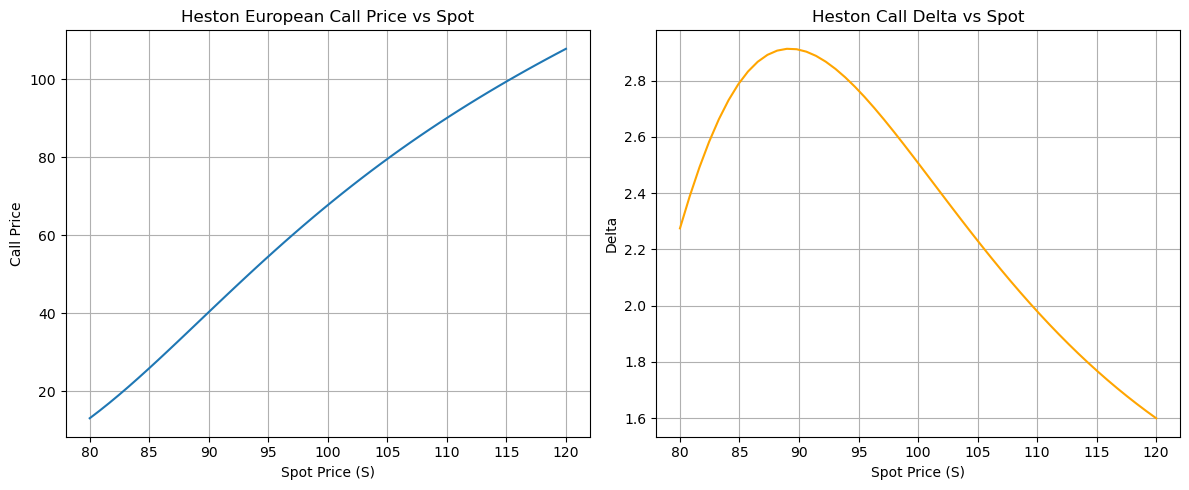

In [5]:
import matplotlib.pyplot as plt
S_vals = np.linspace(80, 120, 50)
prices = []
deltas = []

for s in S_vals:
    prices.append(heston_price(s, K, T, r, v0, kappa, theta, sigma, rho))
    deltas.append(heston_delta(s, K, T, r, v0, kappa, theta, sigma, rho))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(S_vals, prices)
plt.title("Heston European Call Price vs Spot")
plt.xlabel("Spot Price (S)")
plt.ylabel("Call Price")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(S_vals, deltas, color='orange')
plt.title("Heston Call Delta vs Spot")
plt.xlabel("Spot Price (S)")
plt.ylabel("Delta")
plt.grid(True)

plt.tight_layout()
plt.show()

## Parameter Estimation of the Heston Model

Parameter estimation involves calibrating the model's parameters to market data to ensure it accurately reflects real-world option prices (market data).

The model with calibrated parameters enable accurate pricing, effective hedging, and risk analysis in complex derivatives markets.


#### Maximum Likelihood Estimation (MLE)
 -  Maximize likelihood function parameterized by θ